# Korelacje Google trends

Próba zbadania korelacji między zmiany w kursach akcji, dla przykładu Microsoftu (ticker: MSFT), i ilościa wyszukiwań nazwy spółki giełdowej (słowa "Microsoft") w wyszukiwarce google. Pomysł powzięty z artykułu:  https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a

### 1. Wyciągnięcie danych z Google Trends z użyciem nioficjalnego API i biblioteki Pytrends (https://pypi.org/project/pytrends)

In [1]:
import os

wd1 = os.getcwd()
print(wd1)
up1 = os.path.split(wd1)[0]
print(up1)
up2 = os.path.split(up1)[0]
print(up2)
wd2 = os.path.join(up2,"data", "blukasz_data")
print(wd2)
os.chdir(wd2)
print(os.getcwd())

C:\Users\Person\Desktop\WSB\Analysis-and-forecast-of-stock-exchange-price-based-on-selected-indicators-using-machine-learning\scripts\blukasz_scripts
C:\Users\Person\Desktop\WSB\Analysis-and-forecast-of-stock-exchange-price-based-on-selected-indicators-using-machine-learning\scripts
C:\Users\Person\Desktop\WSB\Analysis-and-forecast-of-stock-exchange-price-based-on-selected-indicators-using-machine-learning
C:\Users\Person\Desktop\WSB\Analysis-and-forecast-of-stock-exchange-price-based-on-selected-indicators-using-machine-learning\data\blukasz_data
C:\Users\Person\Desktop\WSB\Analysis-and-forecast-of-stock-exchange-price-based-on-selected-indicators-using-machine-learning\data\blukasz_data


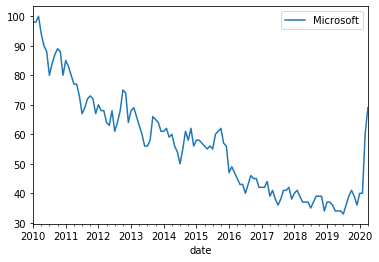

In [2]:
from pytrends.request import TrendReq

pytrend = TrendReq()
pytrend.build_payload(kw_list = ['Microsoft'], timeframe = '2010-01-01 2020-04-30')
df = pytrend.interest_over_time()
df = df.reset_index().drop('isPartial', 1)
df.to_csv('Microsoft_searches.csv')

df.plot(x='date', y='Microsoft', kind ='line')

### 2. Budowa modelu dla powyższych danych z użyciem biblioteki Prophet (https://facebook.github.io/prophet/) i wuzyskanie "changepoints", czyli daty gdy następowła zmiana trendu.

In [3]:
import matplotlib.pyplot as plt
import fbprophet

# Prophet wymaga zmainy nazwy kolumn na ds (Data) i y (wartość)
# Changing column names according to Prohet requirements
df1 = df.rename(columns={'date': 'ds', 'Microsoft': 'y'})

# Dopasowanie modelu Prophet
# Prophet model fitting
fb_prophet = fbprophet.Prophet(changepoint_prior_scale=0.3, n_changepoints=10)
fb_prophet.fit(df1)

# Wyciągnięcie changepoints
# Changepoints extraction
fb_prophet.changepoints[:10]
fb_changepoints = fb_prophet.changepoints
fb_changepoints.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10   2010-11-01
20   2011-09-01
29   2012-06-01
39   2013-04-01
49   2014-02-01
Name: ds, dtype: datetime64[ns]

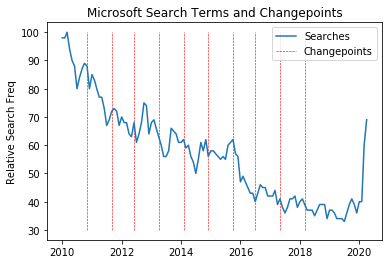

In [4]:
# Wykres trendów wyszukiwań z nałżonymi changepoints
# Relative searches trend with changepoints plot
plt.plot(df['date'], df['Microsoft'], label = 'Searches')

plt.vlines(fb_changepoints, ymin = 30, ymax= 100, colors = 'r', linewidth=0.6,
           linestyles = 'dashed', label = 'Changepoints')
 
plt.ylabel('Relative Search Freq'); plt.legend()
plt.title('Microsoft Search Terms and Changepoints');

### 3. Nałożeniea dat zmian trendu ilości wyszukiwań na historię ceny akcji

In [5]:
import quandl

quandl.ApiConfig.api_key = 'jJLD2gkVUNrszRRebz2U'

# Wyciągnięcie historii dziennej ceny zamknięcia dla akcji Microsoftu
# Microsoft daily closing shares price download
data = quandl.get("WIKI/MSFT", start_date="2010-01-01", end_date="2020-03-31", collapse="monthly")
data1 = data.reset_index()
data1 = data1[['Date','Close']]
data1.to_csv('Microsoft_shares.csv')
data1.tail()

,Date,Close
94,2017-11-30,84.17
95,2017-12-31,85.54
96,2018-01-31,95.01
97,2018-02-28,93.77
98,2018-03-31,89.47


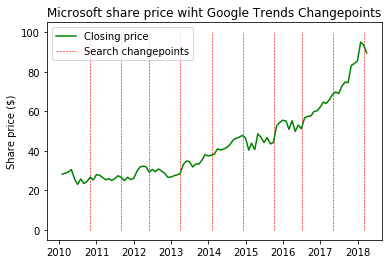

In [20]:
# Wykres cen akcji
# Shares price plot
plt.plot(data1['Date'], data1['Close'], label = 'Closing price', color = 'green')

# Dodanie dat zmian trendu i nazw osi
# Added changepoints changepoints and axis names
plt.vlines(fb_changepoints, ymin = 0, ymax= 100, colors = 'r', linewidth=0.6,
           linestyles = 'dashed', label = 'Search changepoints')
 
plt.ylabel('Share price ($)'); plt.legend()
plt.title('Microsoft share price wiht Google Trends Changepoints');